In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

# 2004, 2008, 2011

import warnings
warnings.filterwarnings("ignore")

drive_url       = "/Users/fsultan_1/Library/CloudStorage/GoogleDrive-syedfahadsultan@gmail.com/My Drive/data/"
completions_url = drive_url+"IPEDS_data/completions"
fnames          = glob(completions_url+'/*_A/*_rv.csv')+glob(completions_url+'/IPEDS/*_a.csv')

dfs     = []

for fname in tqdm(fnames): 

    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year <= 2001:
        continue 

    df          = pd.read_csv(fname, index_col=0)
    df          = df.rename(columns={col: col.upper().strip() for col in df.columns})
    df          = df[df['AWLEVEL'].apply(lambda x: x in [5, 7, 9, 17, 18, 19])]
    df['cs']    = df['CIPCODE'].apply(lambda x: (x>=11) & (x<12))
    df['cs2']   = df['CIPCODE']==11.0701
    df['year']  = year
    df['ugd']   = df['AWLEVEL'] == 5
    df['mst']   = df['AWLEVEL'] == 7
    df['phd']   = df['AWLEVEL'] >  7


    dfs.append(df)

all_dfs                     = pd.concat(dfs)
all_dfs['whitemen_abs']     = all_dfs[['CWHITM', 'CRACE11']].max(axis=1)
all_dfs['women_abs']        = all_dfs[['CTOTALW', 'CRACE16']].max(axis=1)
all_dfs['black_abs']        = all_dfs[['CBKAAT', 'CRACE18', 'DVCBKT']].max(axis=1)
all_dfs['black_men_abs']    = all_dfs[['CBKAAM', 'CRACE03', 'DVCBKM']].max(axis=1) 
all_dfs['black_women_abs']  = all_dfs[['CBKAAW', 'CRACE04', 'DVCBKW']].max(axis=1) 
all_dfs['hisp_abs']         = all_dfs[['CRACE21', 'CHISPT','DVCHST']].max(axis=1)
all_dfs['hisp_men_abs']     = all_dfs[['CRACE09', 'CHISPM','DVCHSM']].max(axis=1)
all_dfs['hisp_women_abs']   = all_dfs[['CRACE10', 'CHISPW','DVCHSW']].max(axis=1)
all_dfs['native_abs']       = all_dfs[['CAIANT', 'CRACE19']].max(axis=1)
all_dfs['total_abs']        = all_dfs[['CRACE24', 'CTOTALT']].max(axis=1)

100%|██████████| 18/18 [00:14<00:00,  1.23it/s]


In [6]:
all_dfs['women_pct'] = all_dfs['women_abs']/all_dfs['total_abs']

In [9]:
cs = all_dfs[all_dfs['cs']]

In [12]:
cs = cs.reset_index()

In [57]:
from scipy.stats import ttest_ind

stats = cs.groupby('UNITID').apply(lambda x: pd.Series(ttest_ind(x['women_pct'], 1-x['women_pct'])))
stats.columns = ['effect', 'pval']
stats = stats.dropna()
stats = stats[~stats['effect'].isin([np.inf, -np.inf])]
sig = stats[stats['pval']<0.01]

In [64]:
len(stats), "%s (-%s)" % (len(sig), str(len(stats)-len(sig))), sum(sig['effect']<0), sum(sig['effect']>0)

(322, '265 (-57)', 260, 5)

In [65]:
ns = stats[stats['pval']>0.01]

<Axes: >

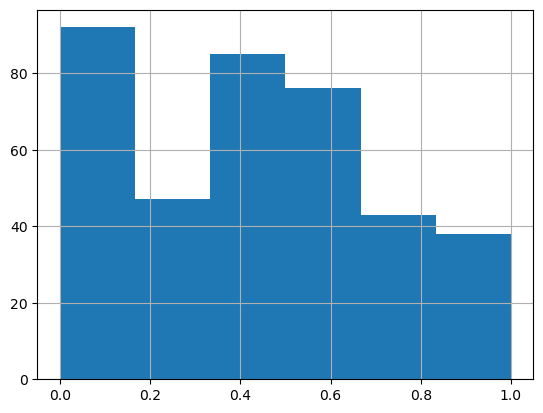

In [70]:
a = all_dfs.loc[ns.index]
a[a['cs']]['women_pct'].hist(bins=6)

<ErrorbarContainer object of 3 artists>

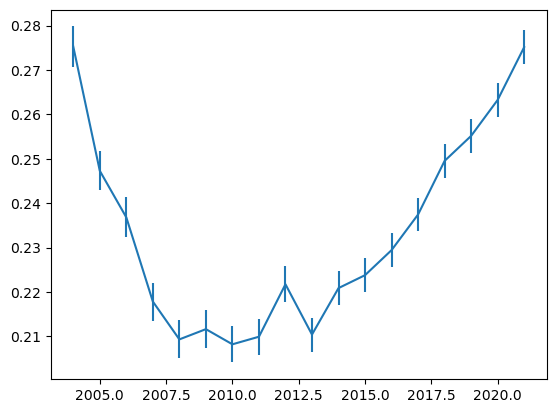

In [17]:

mean_sem = cs.groupby('year').apply(lambda x: pd.Series({'mean': x['women_pct'].mean(), 'sem': x['women_pct'].sem()}))
plt.errorbar(mean_sem.index, mean_sem['mean'], yerr=mean_sem['sem'])